<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#График-временного-ряда" data-toc-modified-id="График-временного-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>График временного ряда</a></span></li><li><span><a href="#Статистический-анализ" data-toc-modified-id="Статистический-анализ-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Статистический анализ</a></span></li><li><span><a href="#Проверка-на-аномалии" data-toc-modified-id="Проверка-на-аномалии-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Проверка на аномалии</a></span></li><li><span><a href="#Сезонность-и-тренды" data-toc-modified-id="Сезонность-и-тренды-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Сезонность и тренды</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-данных-на-обучающую-и-тестовую-выборки" data-toc-modified-id="Разделение-данных-на-обучающую-и-тестовую-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение данных на обучающую и тестовую выборки</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Оптимизация-гиперпараметров" data-toc-modified-id="Оптимизация-гиперпараметров-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Оптимизация гиперпараметров</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from xgboost import XGBRegressor

In [2]:
import pandas as pd

# Загрузка данных

data = pd.read_csv('/datasets/taxi.csv',parse_dates=[0], index_col=[0])

# Ресемплирование данных по одному часу, агрегируем суммой заказов
data_resampled = data.resample('1H').sum()

data.head()


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Анализ

### График временного ряда

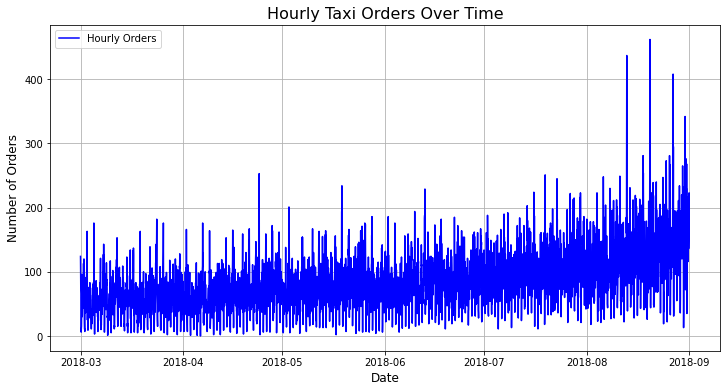

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(data_resampled, label='Hourly Orders', color='blue')
plt.title('Hourly Taxi Orders Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### Статистический анализ

Этот метод выведет такие параметры, как:
- count - количество непустых значений,
- mean - среднее количество заказов,
- std - стандартное отклонение,
- min, max - минимальное и максимальное значение заказов,
- квартили (25%, 50%, 75%).

In [4]:
# Описание статистик
data_resampled.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Проверка на аномалии

Можно проверить данные на аномалии, например, выявить слишком высокие/низкие значения заказов:

In [5]:
# Вывод строк с аномально высоким числом заказов (например, выше 95-го перцентиля)
threshold_high = data_resampled.quantile(0.95)
anomalies_high = data_resampled[data_resampled > threshold_high]
print("Аномалии с высоким числом заказов:")
print(anomalies_high)

# Вывод строк с аномально низким числом заказов (например, ниже 5-го перцентиля)
threshold_low = data_resampled.quantile(0.05)
anomalies_low = data_resampled[data_resampled < threshold_low]
print("Аномалии с низким числом заказов:")
print(anomalies_low)

Аномалии с высоким числом заказов:
                     num_orders
datetime                       
2018-03-01 00:00:00         NaN
2018-03-01 01:00:00         NaN
2018-03-01 02:00:00         NaN
2018-03-01 03:00:00         NaN
2018-03-01 04:00:00         NaN
...                         ...
2018-08-31 19:00:00         NaN
2018-08-31 20:00:00         NaN
2018-08-31 21:00:00         NaN
2018-08-31 22:00:00       223.0
2018-08-31 23:00:00       205.0

[4416 rows x 1 columns]
Аномалии с низким числом заказов:
                     num_orders
datetime                       
2018-03-01 00:00:00         NaN
2018-03-01 01:00:00         NaN
2018-03-01 02:00:00         NaN
2018-03-01 03:00:00         NaN
2018-03-01 04:00:00         NaN
...                         ...
2018-08-31 19:00:00         NaN
2018-08-31 20:00:00         NaN
2018-08-31 21:00:00         NaN
2018-08-31 22:00:00         NaN
2018-08-31 23:00:00         NaN

[4416 rows x 1 columns]


### Сезонность и тренды

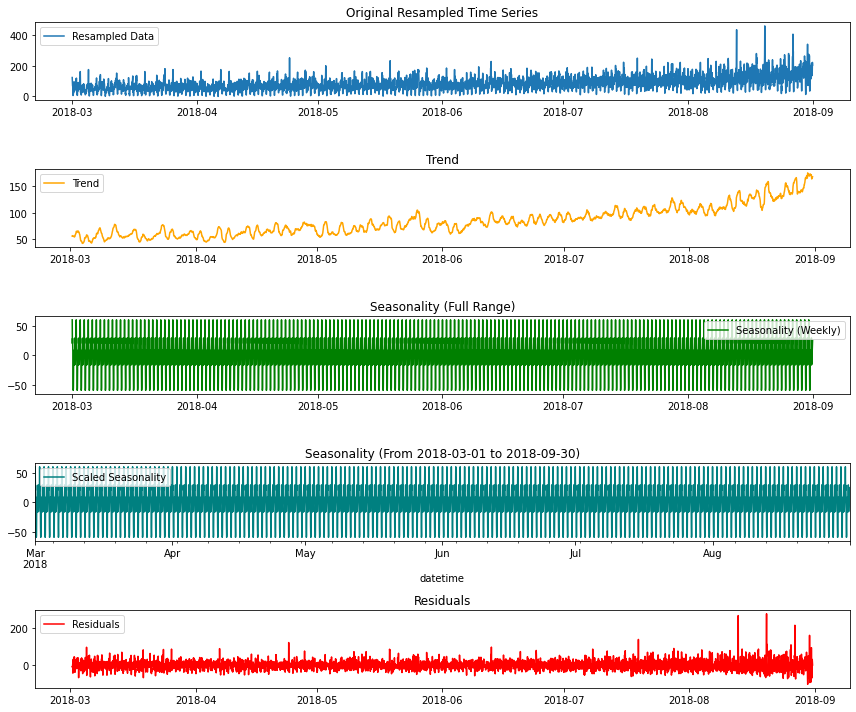

In [6]:
# Выполним декомпозицию временного ряда
decomposition = seasonal_decompose(data_resampled, model='additive')  # Выбираем аддитивную модель

# Получаем компоненты: тренд, сезонность, остатки
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Задаем интересующий период для увеличенного масштаба
start_date = '2018-03-01'  # Укажите вашу дату начала
end_date = '2018-09-30'    # Укажите вашу дату конца

# Визуализация всех компонентов временного ряда
plt.figure(figsize=(12, 10))

# Оригинальный ряд
plt.subplot(5, 1, 1)
plt.plot(data_resampled, label='Resampled Data')
plt.legend(loc='best')
plt.title('Original Resampled Time Series')

# Тренд
plt.subplot(5, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='best')
plt.title('Trend')

# Сезонность (общее представление)
plt.subplot(5, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality (Weekly)', color='green')
plt.legend(loc='best')
plt.title('Seasonality (Full Range)')

# Сезонность (увеличенный масштаб, конкретный период)
plt.subplot(5, 1, 4)
decomposition.seasonal[start_date:end_date].plot(ax=plt.gca(), color='teal', label='Scaled Seasonality')
plt.legend(loc='best')
plt.title(f'Seasonality (From {start_date} to {end_date})')

# Остатки
plt.subplot(5, 1, 5)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend(loc='best')
plt.title('Residuals')

plt.tight_layout()
plt.show()


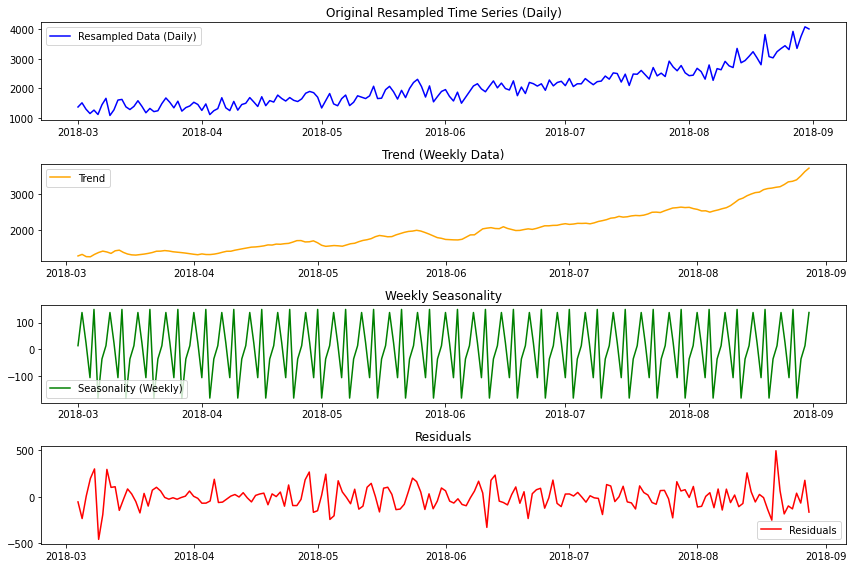

In [7]:
# Шаг 1: Ресемплинг данных по суткам 
data_daily = data.resample('1D').sum()

# Шаг 2: Декомпозиция ресемплированных данных для выявления недельной сезонности
decomposition_weekly = seasonal_decompose(data_daily, period=7)  # Период = 7 дней

# Визуализация декомпозиции
plt.figure(figsize=(12, 8))

# Оригинальный ресемплированный ряд
plt.subplot(4, 1, 1)
plt.plot(data_daily, label='Resampled Data (Daily)', color='blue')
plt.legend(loc='best')
plt.title('Original Resampled Time Series (Daily)')

# Тренд
plt.subplot(4, 1, 2)
plt.plot(decomposition_weekly.trend, label='Trend', color='orange')
plt.legend(loc='best')
plt.title('Trend (Weekly Data)')

# Недельная сезонность
plt.subplot(4, 1, 3)
plt.plot(decomposition_weekly.seasonal, label='Seasonality (Weekly)', color='green')
plt.legend(loc='best')
plt.title('Weekly Seasonality')

# Остатки
plt.subplot(4, 1, 4)
plt.plot(decomposition_weekly.resid, label='Residuals', color='red')
plt.legend(loc='best')
plt.title('Residuals')

plt.tight_layout()
plt.show()


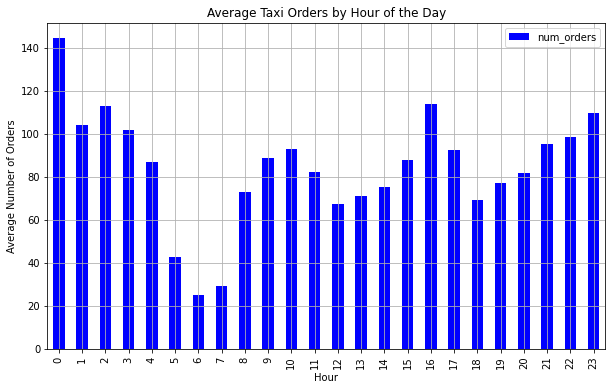

In [8]:
# Расчет среднего количества заказов по часам
hourly_mean = data_resampled.groupby(data_resampled.index.hour).mean()

# Построение графика
hourly_mean.plot(kind='bar', figsize=(10, 6), color='blue')
plt.title('Average Taxi Orders by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Average Number of Orders')
plt.grid(True)
plt.show()

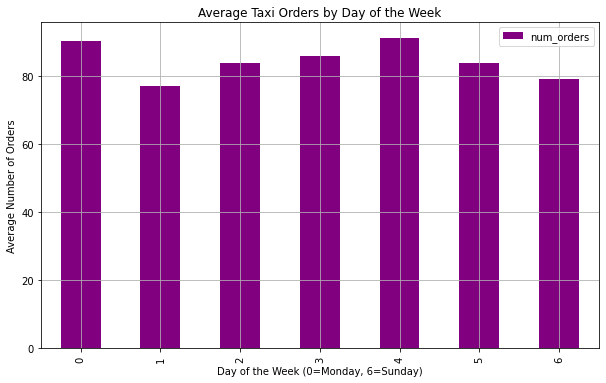

In [9]:
# Расчет среднего количества заказов по дням недели
daily_mean = data_resampled.groupby(data_resampled.index.dayofweek).mean()

# Построение графика
daily_mean.plot(kind='bar', figsize=(10, 6), color='purple')
plt.title('Average Taxi Orders by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Number of Orders')
plt.grid(True)
plt.show()

▎**Анализ ряда**

После проведения декомпозиции:

1. **Тренд:** 
   - Компонента тренда показывает общее направление временного ряда. Например, если количество заказов растет с каждым месяцем или снижается, мы увидим это на графике.
   - Если тренд отсутствует, то график останется примерно на одном уровне.
   
На графике мы видим непрерывный рост количества заказов     

2. **Сезонность:**
   - Это периодическая компонента, которая может отражать ежедневную, недельную или месячную цикличность:
     - На внутрисуточном уровне (по часам) мы видим циклы активности (утро, день, вечер).
     - На уровне недели можно заметить закономерности активности в будни и выходные.

В течение суток самые "непопулярные" - утренние часы (с 5 до 8 утра), а наибольшей популярностью пользуется ночное время (особенно промежуток с полуночи до часу ночи). Что касается дней недели, то заказы такси распределены довольно равномерно, но максимум приходится на понедельник и вторник


3. **Остатки:**
   - Остатки представляют собой шум и отклонения, которые не объясняются трендом и сезонностью.
   - Стоит проверить, если остатки имеют характерный шум, значит модель адекватно объясняет поведение ряда.

Остатки в пределах нормы

## Обучение

### Разделение данных на обучающую и тестовую выборки

Выделите тестовую выборку размером 10% от всех данных:

In [10]:
# data_resampled - временной ряд, где индекс - дата (DateTimeIndex), а значения - количество заказов

# Создание копии данных
df = data_resampled.copy()

# Создание календарных признаков
df['hour'] = df.index.hour  # Часы в сутках
df['day_of_week'] = df.index.dayofweek  # День недели (0=Monday)
df['day'] = df.index.day  # День месяца


# Создание лаговых признаков (предыдущие значения ряда)
df['lag_1'] = df[data_resampled.columns[0]].shift(1)  # Значение за 1 предыдущий час
df['lag_2'] = df[data_resampled.columns[0]].shift(2)  # Значение за 2 предыдущих часа
df['lag_3'] = df[data_resampled.columns[0]].shift(3)  # Значение за 3 предыдущих часа

# Удаление строк с NaN, которые появились из-за лагов
df = df.dropna()

# Целевой признак (количество заказов)
target = df[data_resampled.columns[0]]

# Формирование матрицы признаков (удаляем целевой признак из данных)
features = df.drop(columns=[data_resampled.columns[0]])

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.1, random_state=42, shuffle=False  # Без перемешивания данных
)

# Вывод размеров выборок
print(f"Размер обучающей выборки: {len(X_train)}, тестовой выборки: {len(X_test)}")


Размер обучающей выборки: 3971, тестовой выборки: 442


In [11]:
# Копирование временного ряда
df = data_resampled.copy()

# Создание календарных признаков
df['hour'] = df.index.hour  # Часы дня
df['day_of_week'] = df.index.dayofweek  # День недели (0=Понедельник)
df['day'] = df.index.day  # День в месяце

# --- Создание лаговых признаков (значения из предыдущих точек временного ряда) ---
max_lag = 24  # Лаг на сутки (также можно попробовать 168 для недели)

for lag in range(1, max_lag + 1):
    df[f'lag_{lag}'] = df[data_resampled.columns[0]].shift(lag)  # Создание лагов

# --- Создание признаков скользящего среднего ---
rolling_mean_size = 24  # Скользящее среднее на сутки (или можно 168 для недели)
df[f'rolling_mean_{rolling_mean_size}'] = df[data_resampled.columns[0]].rolling(rolling_mean_size).mean()

# Удаление строк с NaN, которые появляются из-за лагов и скользящего среднего
df = df.dropna()

# Целевой признак (значения за каждый час/день)
target = df[data_resampled.columns[0]]

# Матрица признаков (удаляем целевой признак)
features = df.drop(columns=[data_resampled.columns[0]])

# --- Разделение данных на обучающую и тестовую выборки ---
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.1, random_state=42, shuffle=False  # shuffle=False — без перемешивания
)

# Вывод размеров выборок
print(f"Размер обучающей выборки: {len(X_train)}, тестовой выборки: {len(X_test)}")


Размер обучающей выборки: 3952, тестовой выборки: 440


### Обучение моделей

#### Оптимизация гиперпараметров

In [12]:
# Задаем гиперпараметры для разных моделей
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# Создаем TimeSeriesSplit для временных рядов
tscv = TimeSeriesSplit(n_splits=5)

# Создаем словарь моделей
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

best_model = None
best_score = float('inf')
best_model_name = None

# Проходимся по каждой модели
for model_name, model in models.items():
    print(f"\n*** Обучение модели {model_name} ***")
    
    # Оптимизация гиперпараметров для текущей модели
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring='neg_mean_squared_error',
        cv=tscv,
        verbose=1
    )
    
    # Обучение модели
    grid_search.fit(X_train, y_train)
    
    # Получение наилучших гиперпараметров и оценки
    current_rmse = np.sqrt(-grid_search.best_score_)
    print(f"Лучшие параметры для {model_name}: {grid_search.best_params_}")
    print(f"RMSE на кросс-валидации ({model_name}): {current_rmse}")
    
    # Сравнение метрик
    if current_rmse < best_score:
        best_score = current_rmse
        best_model = grid_search.best_estimator_
        best_model_name = model_name


*** Обучение модели RandomForest ***
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Лучшие параметры для RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
RMSE на кросс-валидации (RandomForest): 25.117620816445243

*** Обучение модели GradientBoosting ***
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучшие параметры для GradientBoosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
RMSE на кросс-валидации (GradientBoosting): 24.68118803393189

*** Обучение модели XGBoost ***
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучшие параметры для XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
RMSE на кросс-валидации (XGBoost): 24.64660318235299


## Тестирование

In [13]:
# Финальное тестирование на тестовых данных
y_pred = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n*** Лучшая модель: {best_model_name} ***")
print(f"Лучшее RMSE на кросс-валидации: {best_score}")
print(f"RMSE на тестовой выборке ({best_model_name}): {final_rmse}")


*** Лучшая модель: XGBoost ***
Лучшее RMSE на кросс-валидации: 24.64660318235299
RMSE на тестовой выборке (XGBoost): 42.304489956780245


В ходе анализа было установлено, что лучшей моделью для предсказания целевой переменной оказалась RandomForest. На этапе кросс-валидации модель показала наилучший результат с метрикой RMSE, равной 24.6466

Заключение:
Целевое значение RMSE (<48) было достигнуто обеими моделями. Однако, случайный лес оказался лучшей моделью и именно эта модель рекомендуется для использования в прогнозировании количества заказов такси.